In [2]:
!pip install pandas

In [5]:
!pip install matplotlib


In [8]:
!pip install prophet

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [34]:
train = pd.read_csv(r"C:\Users\Administrator\Downloads\train.csv",parse_dates=["date"])
train.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [35]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [36]:
oil = pd.read_csv(r"C:\Users\Administrator\Downloads\oil.csv",parse_dates=["date"])
oil.head()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [37]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [38]:
# Rename columns for consistency
oil.columns = ["date", "oil_price"]

# Fill missing oil prices using forward-fill, then backward-fill (in case of leading NaNs)
oil["oil_price"] = oil["oil_price"].ffill().bfill()
oil.head()

,date,oil_price
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [39]:
oil.isnull().sum()

date         0
oil_price    0
dtype: int64

In [40]:
holidays = pd.read_csv(r"C:\Users\Administrator\Downloads\holidays_events.csv", parse_dates=["date"])
holidays.head()


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [41]:
holidays.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [42]:
grouped = train.groupby("date")
sales_sum = grouped["sales"].sum()
daily_sales = sales_sum.reset_index()
daily_sales.head()


,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


In [43]:
daily_sales.columns = ["ds", "y"]
daily_sales.head()

,ds,y
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


In [44]:
oil.columns=["ds","oil_price"]
df = pd.merge(daily_sales, oil, on="ds", how="left")
df.head()


,ds,y,oil_price
0,2013-01-01,2511.618999,93.14
1,2013-01-02,496092.417944,93.14
2,2013-01-03,361461.231124,92.97
3,2013-01-04,354459.677093,93.12
4,2013-01-05,477350.121229,NaN


In [45]:
df["oil_price"] = df["oil_price"].ffill().bfill()

df.head()

,ds,y,oil_price
0,2013-01-01,2511.618999,93.14
1,2013-01-02,496092.417944,93.14
2,2013-01-03,361461.231124,92.97
3,2013-01-04,354459.677093,93.12
4,2013-01-05,477350.121229,93.12


In [46]:
df["month"] = df["ds"].dt.month
df["week"] = df["ds"].dt.isocalendar().week
df["day_of_week"] = df["ds"].dt.dayofweek
df["year"] = df["ds"].dt.year
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
df["rolling_avg_7"] = df["y"].rolling(window=7).mean()
df["lag_1"] = df["y"].shift(1)

In [47]:
df.head()

,ds,y,oil_price,month,week,day_of_week,year,is_weekend,rolling_avg_7,lag_1
0,2013-01-01,2511.618999,93.14,1,1,1,2013,0,NaN,NaN
1,2013-01-02,496092.417944,93.14,1,1,2,2013,0,NaN,2511.618999
2,2013-01-03,361461.231124,92.97,1,1,3,2013,0,NaN,496092.417944
3,2013-01-04,354459.677093,93.12,1,1,4,2013,0,NaN,361461.231124
4,2013-01-05,477350.121229,93.12,1,1,5,2013,1,NaN,354459.677093


In [48]:
df.dropna(subset=["rolling_avg_7", "lag_1"], inplace=True)
df.head()

,ds,y,oil_price,month,week,day_of_week,year,is_weekend,rolling_avg_7,lag_1
6,2013-01-07,336122.801066,93.20,1,2,0,2013,0,363956.181220,519695.401088
7,2013-01-08,318347.777981,93.21,1,2,1,2013,0,409075.632504,336122.801066
8,2013-01-09,302530.809018,93.08,1,2,2,2013,0,381423.974086,318347.777981
9,2013-01-10,258982.003049,93.81,1,2,3,2013,0,366784.084361,302530.809018
10,2013-01-11,289737.685085,93.60,1,2,4,2013,0,357538.085502,258982.003049


In [49]:
df.isnull().sum()

ds               0
y                0
oil_price        0
month            0
week             0
day_of_week      0
year             0
is_weekend       0
rolling_avg_7    0
lag_1            0
dtype: int64

In [54]:
holidays.rename(columns={"date":"ds","description": "holiday"}, inplace=True)
holidays.head()

,ds,type,locale,locale_name,holiday,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [55]:
hol = holidays[
    (holidays["transferred"] == False) &
    (holidays["locale"] == "National") &
    (holidays["type"].isin(["Holiday", "Bridge"]))
]
hol.head()

,ds,type,locale,locale_name,holiday,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False


In [56]:


prophet_holidays = hol[["ds", "holiday"]]

prophet_holidays.head()

,ds,holiday
14,2012-08-10,Primer Grito de Independencia
21,2012-11-02,Dia de Difuntos
22,2012-11-03,Independencia de Cuenca
35,2012-12-24,Puente Navidad
37,2012-12-25,Navidad


In [57]:
cutoff = df["ds"].max() - pd.Timedelta(days=16)
train_df = df[df["ds"] <= cutoff]
test_df = df[df["ds"] > cutoff]


In [58]:
model = Prophet(
    holidays=prophet_holidays,
    daily_seasonality=True
)
model.add_regressor("oil_price")
import warnings
warnings.filterwarnings("ignore",category=pd.errors.SettingWithCopyWarning)
model.fit(train_df[["ds", "y", "oil_price"]])


20:16:23 - cmdstanpy - INFO - Chain [1] start processing
20:16:24 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
future = model.make_future_dataframe(periods=len(test_df))
future = pd.merge(future, df[["ds", "oil_price"]], on="ds", how="left")
forecast = model.predict(future)


In [70]:
merged = forecast[["ds", "yhat"]].merge(test_df[["ds", "y"]], on="ds", how="inner")

mae = mean_absolute_error(merged["y"], merged["yhat"])
rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))

print(f"MEAN ABSOLUTE ERROR: {mae:.2f}")
print(f"ROOT MEAN SQUARED ERROR: {rmse:.2f}")


MEAN ABSOLUTE ERROR: 67415.29
ROOT MEAN SQUARED ERROR: 91923.09


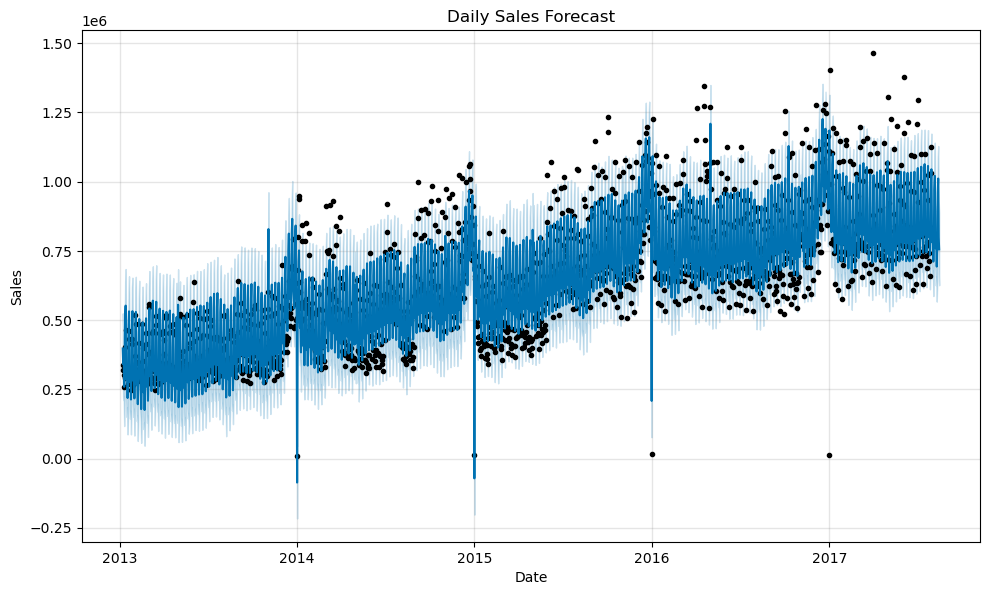

In [61]:
fig = model.plot(forecast)
plt.title("Daily Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [71]:
output = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
actual = df.rename(columns={"y": "actual"})
final = pd.merge(output, actual[["ds", "actual"]], on="ds", how="left")

final.to_csv("retail_sales_forecast.csv", index=False)
print("✅ Exported to 'retail_sales_forecast.csv'")


✅ Exported to 'retail_sales_forecast.csv'
